In [2]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


Importing plotly failed. Interactive plots will not work.


## Load data

In [3]:
df = pd.read_csv('./../../error_dfs/error_2018_2019_ARIMA.csv', converters={'ags2': str, 'ags5': str} )

In [4]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [5]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
0,01001,2018-01-31,9.3,9.028416,0.271584,01,Schleswig-Holstein,"Flensburg, Stadt"
1,01001,2018-02-28,9.2,9.031855,0.168145,01,Schleswig-Holstein,"Flensburg, Stadt"
2,01001,2018-03-31,9.1,8.909250,0.190750,01,Schleswig-Holstein,"Flensburg, Stadt"
3,01001,2018-04-30,8.8,8.975852,0.175852,01,Schleswig-Holstein,"Flensburg, Stadt"
4,01001,2018-05-31,8.3,8.727940,0.427940,01,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...,...
9619,16077,2019-08-31,7.0,7.006511,0.006511,16,Thüringen,Altenburger Land
9620,16077,2019-09-30,6.5,6.842809,0.342809,16,Thüringen,Altenburger Land
9621,16077,2019-10-31,6.5,6.451817,0.048183,16,Thüringen,Altenburger Land
9622,16077,2019-11-30,6.3,6.456085,0.156085,16,Thüringen,Altenburger Land


In [7]:
set(df['bundesland'])

{'Baden-Württemberg',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Freistaat Bayern',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen'}

## Plot each variable

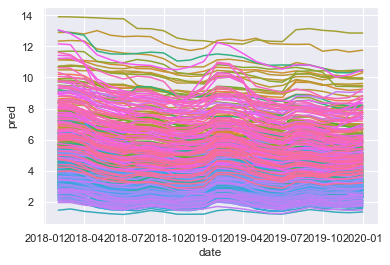

In [11]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.legend_.remove()

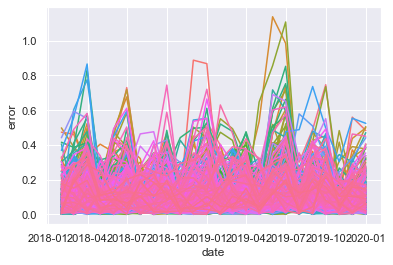

In [12]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.legend_.remove()

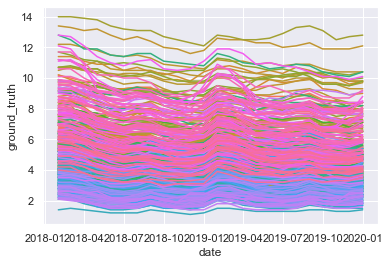

In [13]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.legend_.remove()

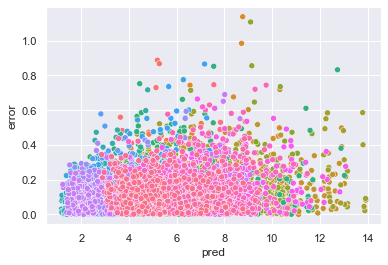

In [14]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [15]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [16]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [17]:
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

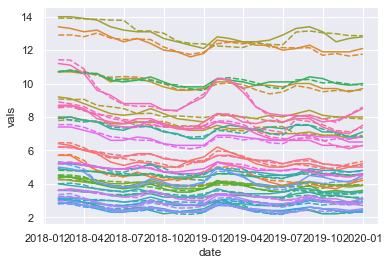

In [18]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.legend_.remove()

## Look into mean errors

In [19]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.137500,8.120935,0.282052
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",7.883333,7.955254,0.152048
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.525000,7.533600,0.126959
01004,01,Schleswig-Holstein,"Neumünster, Stadt",8.125000,8.105459,0.126231
01051,01,Schleswig-Holstein,Dithmarschen,5.887500,5.946776,0.133609
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.375000,5.363375,0.116540
16074,16,Thüringen,Saale-Holzland-Kreis,4.329167,4.330630,0.130186
16075,16,Thüringen,Saale-Orla-Kreis,4.733333,4.744802,0.136998


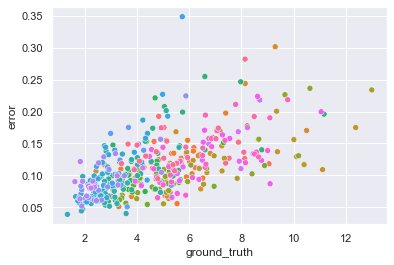

In [20]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

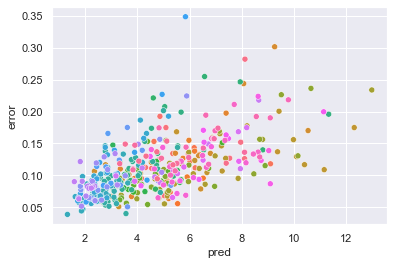

In [21]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [22]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
09464,09,Freistaat Bayern,Hof,5.729167,5.841161,0.348444
03401,03,Niedersachsen,Delmenhorst,9.291667,9.256523,0.301434
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.137500,8.120935,0.282052
07311,07,Rheinland-Pfalz,Stadt Frankenthal (Pfalz),6.595833,6.573322,0.254825
07314,07,Rheinland-Pfalz,Stadt Ludwigshafen a. Rh.,7.970833,7.938000,0.246482
...,...,...,...,...,...,...
09562,09,Freistaat Bayern,Erlangen,3.616667,3.621734,0.050819
09174,09,Freistaat Bayern,Dachau,1.912500,1.911643,0.047151
09175,09,Freistaat Bayern,Ebersberg,1.862500,1.856461,0.044378


<AxesSubplot:xlabel='error', ylabel='Density'>

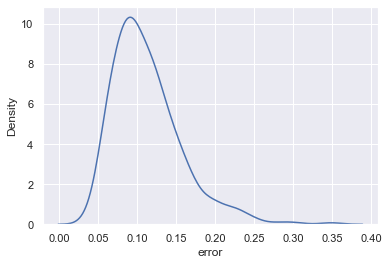

In [23]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [24]:
df.sort_values(by = ['error'], ascending=False)

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
1072,03401,2019-05-31,9.9,8.761884,1.138116,03,Niedersachsen,Delmenhorst
2561,05914,2019-06-30,10.2,9.092010,1.107990,05,Nordrhein-Westfalen,Hagen
1073,03401,2019-06-30,9.7,8.715010,0.984990,03,Niedersachsen,Delmenhorst
274,01059,2018-11-30,4.3,5.188028,0.888028,01,Schleswig-Holstein,Schleswig-Flensburg
275,01059,2018-12-31,4.4,5.268043,0.868043,01,Schleswig-Holstein,Schleswig-Flensburg
...,...,...,...,...,...,...,...,...
1154,03405,2018-03-31,11.1,11.099951,0.000049,03,Niedersachsen,Wilhelmshaven
2023,05366,2018-08-31,5.2,5.200034,0.000034,05,Nordrhein-Westfalen,Euskirchen
6256,09371,2019-05-31,2.0,2.000016,0.000016,09,Freistaat Bayern,Amberg-Sulzbach
207,01056,2019-04-30,4.5,4.500014,0.000014,01,Schleswig-Holstein,Pinneberg


In [25]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

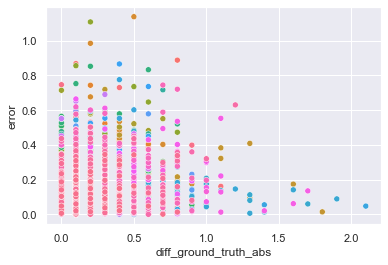

In [26]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

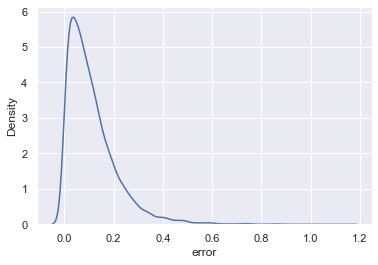

In [27]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

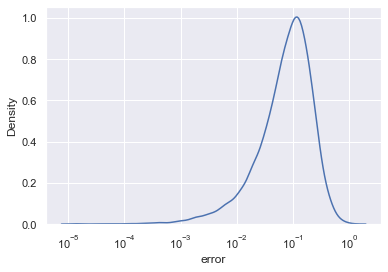

In [28]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [30]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_/_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,2,99,99,1,1,C,1
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,1,99,99,1,0,C/D,1
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,1,5,99,1,0,C/D,1
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,2,5,99,1,0,D,1
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,2,5,99,1,0,C,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,2,99,99,2,0,C*,1
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,2,99,99,2,0,C*,1
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,2,99,99,2,2,C*,1
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,1,99,99,2,0,C*,1


### Merge to df with mean errors

In [31]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [32]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

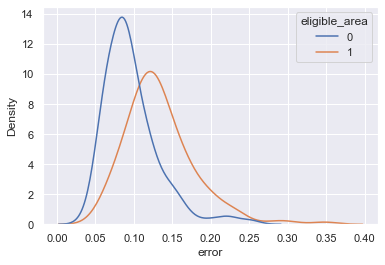

Ttest_indResult(statistic=8.690825006084157, pvalue=2.0739468708599833e-16)

In [33]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

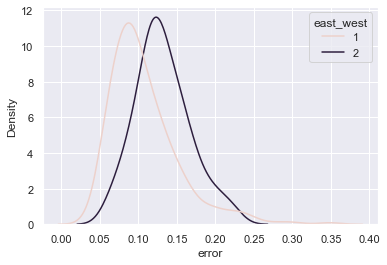

Ttest_indResult(statistic=-5.054424895786579, pvalue=1.3049984973240593e-06)

In [34]:
compare_error_in_two_groups(df_mixed, 'east_west')

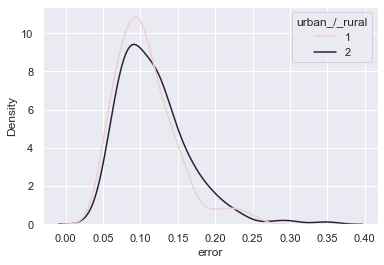

Ttest_indResult(statistic=-2.310066399284483, pvalue=0.02139997586737532)

In [35]:
compare_error_in_two_groups(df_mixed, 'urban_/_rural')

### Compare compare error in multiple groups

In [36]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

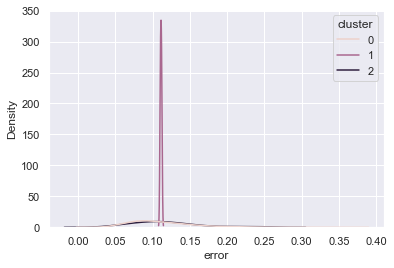

            sum_sq     df         F    PR(>F)
cluster   0.001484    1.0  0.750617  0.386802
Residual  0.788888  399.0       NaN       NaN


In [37]:
compare_error_in_two_groups(df_mixed, "cluster")

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


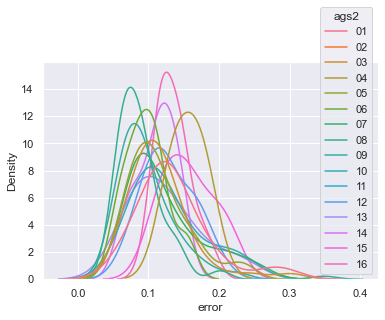

            sum_sq     df         F        PR(>F)
ags2      0.113435   15.0  4.301003  1.959408e-07
Residual  0.676937  385.0       NaN           NaN


In [38]:
compare_error_in_two_groups(df_mixed, "ags2")

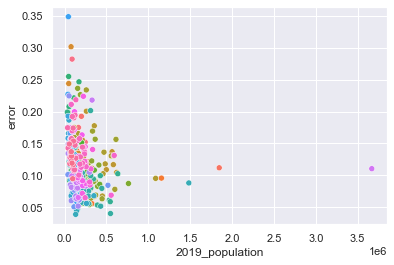

In [39]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

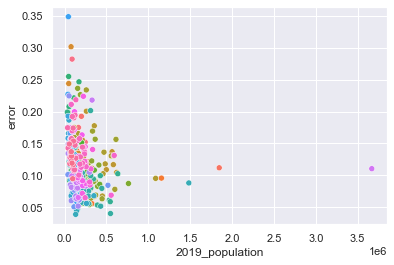

In [40]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [41]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [42]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_/_rural'] = df_mixed['urban_/_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [43]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [44]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.4953 -0.1146    -0.0 0.1077 0.5864


Coefficients:
                                                    Estimate                  Std. Error          t value   p value
_intercept                                       -119.170145  2.095092e+05+1.000000e-05j  -0.0006+0.0000j  0.999546
supermarkets_population                             0.009394 -5.158000e-03-0.000000e+00j  -1.8212+0.0002j  0.069322
supermarkets_average_distance                       0.000127 -4.730000e-04+6.420000e-04j  -0.0943-0.1280j  0.873771
public_transport_availability                       0.008015  4.201000e-03-1.000000e-05j   1.9078+0.0047j  0.057126
average_distance_bus_stop                          -0.000022  2.110000e-04-6.200000e-05j  -0.0973-0.0285j  0.919324
average_distance_train_station                      0.000038  1.900000e-05+1.200000e-05j   1.3985-0.9277j  0.094089
average_distance_public_transport                   0.000194 -1.100000e-05+1.220000e-

### Sequential Feature Selector

In [45]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [46]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(150,)","[0.2145579359320099, 0.3011742963469707, 0.321...",0.254065,"(purchasing_power_per_household,)",0.081822,0.06366,0.03183
2,"(150, 152)","[0.30533782985019164, 0.29943059606134925, 0.4...",0.326495,"(purchasing_power_per_household, debtor_quota)",0.110221,0.085755,0.042878
3,"(69, 150, 152)","[0.3477701806485989, 0.29872270711641735, 0.52...",0.390912,"(Number_of_Commuters_on_place_of_residence), p...",0.114095,0.08877,0.044385
4,"(69, 150, 152, 160)","[0.348757063135384, 0.2835987804756016, 0.5477...",0.404403,"(Number_of_Commuters_on_place_of_residence), p...",0.119764,0.093181,0.04659
5,"(36, 69, 150, 152, 160)","[0.3694440693617812, 0.27260220833672955, 0.58...",0.419274,"(municipal_tax_per_capita.1, Number_of_Commute...",0.143795,0.111877,0.055939
6,"(36, 69, 150, 152, 160, 163)","[0.38621603986061503, 0.27915136712362043, 0.5...",0.433014,"(municipal_tax_per_capita.1, Number_of_Commute...",0.141458,0.11006,0.05503
7,"(36, 69, 83, 150, 152, 160, 163)","[0.38676814077425803, 0.28958336536467977, 0.5...",0.440184,"(municipal_tax_per_capita.1, Number_of_Commute...",0.139716,0.108704,0.054352
8,"(36, 69, 83, 150, 152, 160, 163, 185)","[0.3967373189597806, 0.27795650365583546, 0.58...",0.449173,"(municipal_tax_per_capita.1, Number_of_Commute...",0.143977,0.112019,0.05601
9,"(36, 69, 76, 83, 150, 152, 160, 163, 185)","[0.4091702956499983, 0.29697454566975157, 0.56...",0.453896,"(municipal_tax_per_capita.1, Number_of_Commute...",0.124994,0.09725,0.048625
10,"(36, 69, 76, 83, 119, 150, 152, 160, 163, 185)","[0.3663619877986424, 0.35666113730343685, 0.57...",0.460874,"(municipal_tax_per_capita.1, Number_of_Commute...",0.121874,0.094822,0.047411


In [47]:
list(summary_table_select['feature_names'])[:5]

[('purchasing_power_per_household',),
 ('purchasing_power_per_household', 'debtor_quota'),
 ('Number_of_Commuters_on_place_of_residence)',
  'purchasing_power_per_household',
  'debtor_quota'),
 ('Number_of_Commuters_on_place_of_residence)',
  'purchasing_power_per_household',
  'debtor_quota',
  'growing_/_shrinking_circles'),
 ('municipal_tax_per_capita.1',
  'Number_of_Commuters_on_place_of_residence)',
  'purchasing_power_per_household',
  'debtor_quota',
  'growing_/_shrinking_circles')]

### Ridge

In [48]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [49]:
stats.summary(rr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q   Max
-0.5334 -0.1179 -0.0016 0.1178 0.592


Coefficients:
                                                   Estimate                  Std. Error          t value   p value
_intercept                                       -21.757879  2.125311e+05+1.000000e-05j  -0.0001+0.0000j  0.999918
supermarkets_population                            0.008928  2.281000e-03+3.030000e-04j   3.8458-0.5116j  0.000122
supermarkets_average_distance                      0.000149  9.940000e-04+1.307000e-03j   0.0550-0.0722j  0.927726
public_transport_availability                      0.006979  8.170000e-04+4.590000e-04j   6.4904-3.6483j  0.000000
average_distance_bus_stop                         -0.000041  2.070000e-04-7.500000e-05j  -0.1753-0.0637j  0.852167
average_distance_train_station                     0.000035  5.300000e-05+3.000000e-06j   0.6662-0.0357j  0.505073
average_distance_public_transport                  0.000182  6.000000e-05-1.090000e-04j   0.70

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

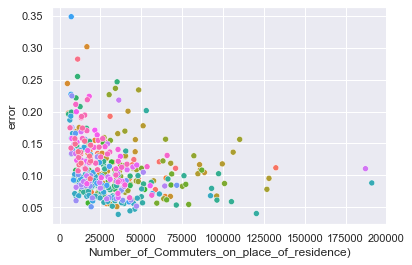

In [50]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.legend_.remove()

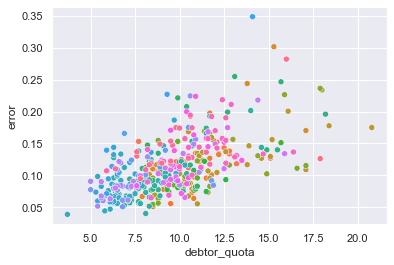

In [51]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

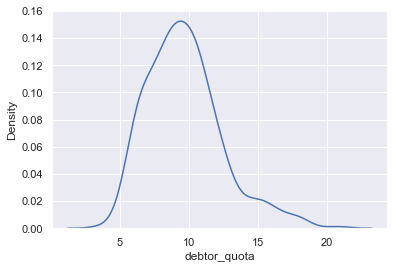

In [52]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

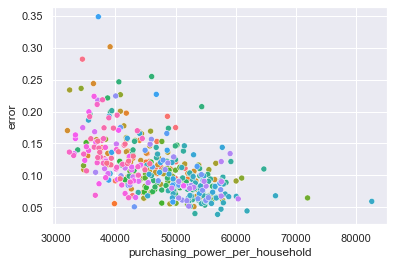

In [53]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

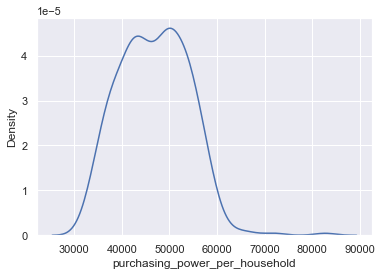

In [54]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

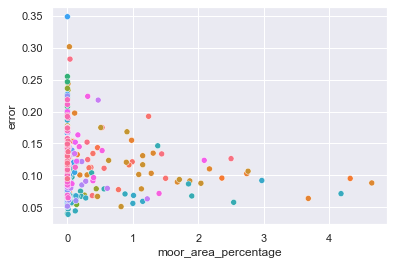

In [55]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()